<a href="https://colab.research.google.com/github/mlites/mlites2019/blob/master/intro_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Clustering

Hello! This lesson will introduce you to Clustering using a number of Unsupervised Machine Learning algorithms. Along the way, we'll learn about feature scaling, feature selection, expectation maximization, and other tools in the machine learning toolbox.

### sklearn clustering algorithms
sklearn has [lots of clustering algorithms](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) to choose from,  including k-means, DBSCAN, Agglomerative Clustering, Spectral Clustering, and Gaussian Mixture Modeling. We'll talk about those here and leave the others for future exploration. Each of them has their strengths and weaknesses, and may or may not be applicable to any given clustering task.

![sklearn clustering algorithms](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

### setup
If you haven't already, make sure to run [kaggle_introduction.ipynb](https://colab.research.google.com/github/mlites/mlites2019/blob/master/kaggle_introduction.ipynb) to download the necessary datasets and set up the environment.

## Genomic Dataset Background

The dataset we'll use for this lesson is based on the Kaggle dataset [Decontamination of Microbial Genomes](https://www.kaggle.com/rec3141/biol342-genome-data). The dataset is the result of 3 years of student work in the General Microbiology course at the University of Alaska Fairbanks. In each year, students cultured a microorganism from the environment and subjected it to DNA sequencing.

For various reasons, some of the cultures were impure, containing 2, 3, or more microorganisms. The goal of our unsupervised machine learning clustering is to separate out (i.e. label) the fragments of DNA belonging to each of the microorganisms.

The dataset is organized by anonymized student ids ("samples") and DNA fragments, which are also known as contigs (for "contiguous sequences"). These contigs have been assembled from raw DNA reads using an *assembler* called SPAdes after various quality control steps. The contigs are named sequentially by student id and order by decreasing length, e.g. student0_1, student0_2, student0_3, etc. More detailed information about the dataset can be found [here](https://www.kaggle.com/rec3141/biol342-genome-data).

The dataset consists of 5 files, although for now we'll focus just on the 1st file.

1. biol342_cov_len_gc.tsv
    * contains the sequencing coverage, length, and G+C content of each contig
2. biol342_depths.tsv
    * containing the sequencing depth of each contig in each sample
3. biol342_paired.tsv
    * contains the number of raw reads spanning each pair of contigs
4. biol342_tax.tsv
    * contains taxonomic labels based on comparison to a large database
5. biol342_tnf.tsv
    * contains the tetranucleotide frequencies of each contig


## Visualizing the data

It's always a good idea to start off by looking at some of the data.

Let's read it into a pandas dataframe



In [1]:
import pandas as pd
#note the use of the sep="\t" option to tell pandas that the data is tab-separated
clg = pd.read_csv("biol342_cov_len_gc.tsv",sep='\t') 

# note that .cov() is a pandas dataframe function to calculate the pairwise covariance of columns
clg.cov()

# so it's best if we rename the 'cov' column to 'coverage'
clg.rename(columns={'cov':'coverage'},inplace=True)

clg.head()

,contig,student,coverage,len,gc
0,student0_1,student0,29.0114,255873,0.4995
1,student0_2,student0,31.5053,190425,0.5151
2,student0_3,student0,39.5121,149891,0.5077
3,student0_4,student0,37.9206,135958,0.5212
4,student0_5,student0,34.0143,121845,0.5204


What kind of data do we have?

The main data types for pandas dataframes are:
* int64 - whole numbers
* float - decimals
* object - most general type, mixed numbers and letters
* category - assigned labels such as [small, medium, large]
* datetime

In [2]:
clg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142380 entries, 0 to 142379
Data columns (total 5 columns):
contig      142380 non-null object
student     142380 non-null object
coverage    142380 non-null float64
len         142380 non-null int64
gc          142380 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.4+ MB


Let's first take a broad look at the distributions of the data using pandas describe() function.

In [3]:
clg.describe()

,coverage,len,gc
count,142380.000000,1.423800e+05,142380.000000
mean,7.596764,4.278103e+03,0.531938
std,36.686146,2.396245e+04,0.136685
min,0.000000,1.280000e+02,0.000000
25%,1.258200,5.110000e+02,0.418200
50%,1.995800,7.480000e+02,0.537300
75%,3.864225,1.560000e+03,0.630100
max,2647.348100,2.231226e+06,1.000000


Next look at the distributions using the hist() function in matplotlib to make a histogram.

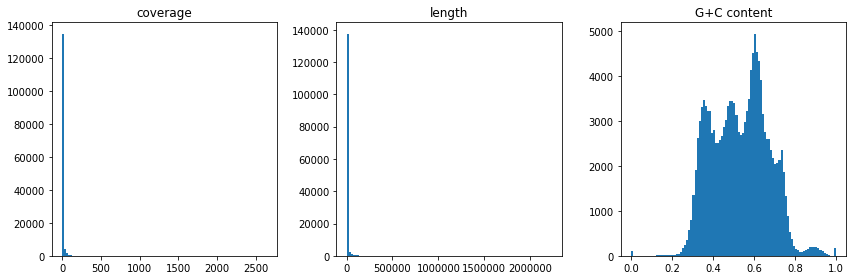

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
hist_cov = plt.hist(clg.coverage, 100)
plt.title("coverage")

plt.subplot(1,3,2)
hist_len = plt.hist(clg.len, 100)
plt.title("length")

plt.subplot(1,3,3)
hist_gc = plt.hist(clg.gc, 100)
plt.title("G+C content")

plt.tight_layout()
plt.show()

It looks like the coverage and length data have very long right tails. In cases like this it is often useful to transform the data.

One simple transform is to use the logarithms instead. Let's try that and re-plot the data.

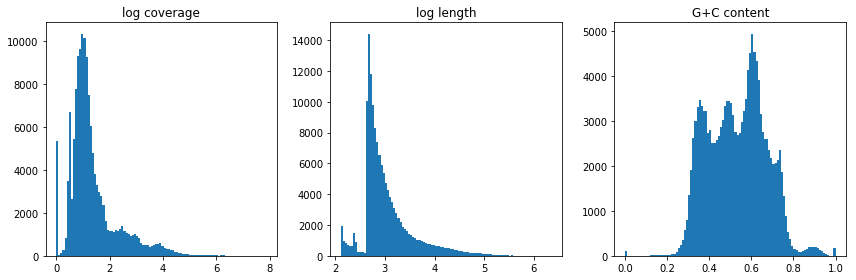

In [5]:
import math
import numpy as np

# add new log-transformed features to the dataset
# need to use np.log rather than math.log when working with numpy arrays
# also using np.log1p because some of the coverages are zeros and log(0) is indefinite
clg["log_coverage"] = np.log1p(clg["coverage"]) 
clg["log_len"] = np.log10(clg["len"])

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
hist_cov = plt.hist(clg.log_coverage, 100)
plt.title("log coverage")

plt.subplot(1,3,2)
hist_len = plt.hist(clg.log_len, 100)
plt.title("log length")

plt.subplot(1,3,3)
hist_gc = plt.hist(clg.gc, 100)
plt.title("G+C content")

plt.tight_layout()
plt.show()

That looks much better, but we can also try another transform called the Box-Cox power transform, which can be called from sklearn.

https://scikit-learn.org/stable/modules/preprocessing.html

In [0]:
import sklearn
from sklearn.preprocessing import PowerTransformer

# add new Box-Cox transformed features to the dataset
# need to pass pandas columns to sklearn as an array like this: [clg["coverage"]]
pt = PowerTransformer()
pt.fit([clg["coverage"].values])
clg["boxcox_coverage"] = pt.transform([clg["coverage"]])

clg["boxcox_len"] = PowerTransformer().fit([clg["len"]]).transform([clg["len"]])

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
hist_cov = plt.hist(clg.boxcox_coverage, 100)
plt.title("Box-Cox coverage")

plt.subplot(1,3,2)
hist_len = plt.hist(clg.boxcox_len, 100)
plt.title("Box-Cox length")

plt.subplot(1,3,3)
hist_gc = plt.hist(clg.gc, 100)
plt.title("G+C content")

plt.tight_layout()
plt.show()

Now let's take a subset of data from a single student.

Here's a few different way to do the same task, which is called *subsetting* or *slicing* the array.


In [6]:
print("select rows where index 'student' equals 'student0' using dot notation")
stu = clg[clg.student=="student0"]
print(stu.head())

print("select rows where index 'student' equals 'student0' using index notation")
stu = clg[clg['student']=="student0"]
print(stu.head())

print("generate a boolean which is True when index 'student' equals 'student0'")
pick_stu = clg['student']=="student0"
stu = clg[pick_stu]
print(stu.head())

print("use matching via the isin() function")
pick_stu = ['student0']
stu = clg[clg.student.isin(pick_stu)]
print(stu.head())

print("selecting on multiple conditions")
pick_stu = ['student0']
stu = clg[clg.student.isin(pick_stu) & (clg.gc > 0.5)] #the parantheses around the second comparison are required
print(stu.head())

print("selecting the inverse")
pick_stu = ['student0']
stu = clg[~clg.student.isin(pick_stu)]
print(stu.head())



select rows where index 'student' equals 'student0' using dot notation
       contig   student  coverage     len      gc  log_coverage   log_len
0  student0_1  student0   29.0114  255873  0.4995      3.401577  5.408024
1  student0_2  student0   31.5053  190425  0.5151      3.481403  5.279724
2  student0_3  student0   39.5121  149891  0.5077      3.701601  5.175776
3  student0_4  student0   37.9206  135958  0.5212      3.661524  5.133405
4  student0_5  student0   34.0143  121845  0.5204      3.555757  5.085808
select rows where index 'student' equals 'student0' using index notation
       contig   student  coverage     len      gc  log_coverage   log_len
0  student0_1  student0   29.0114  255873  0.4995      3.401577  5.408024
1  student0_2  student0   31.5053  190425  0.5151      3.481403  5.279724
2  student0_3  student0   39.5121  149891  0.5077      3.701601  5.175776
3  student0_4  student0   37.9206  135958  0.5212      3.661524  5.133405
4  student0_5  student0   34.0143  121845 

And now we'll go ahead and plot all of the samples dynamically using the log transformed data

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

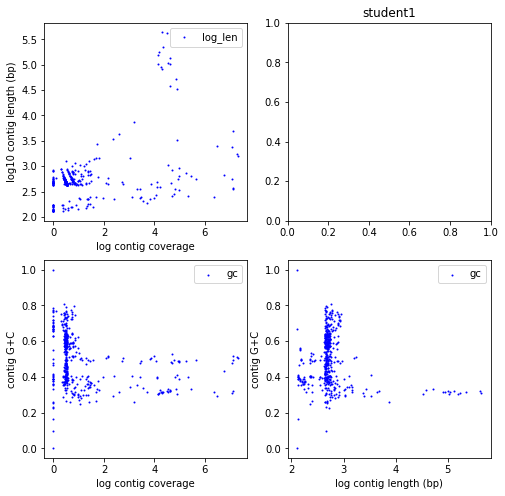

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [8]:
from google.colab import widgets
import matplotlib.pyplot as plt
import time

grid = widgets.Grid(1, 1)
students = clg.student.unique()
for sid in students:
  stu = clg[clg.student==sid]
  with grid.output_to(0, 0):
    grid.clear_cell()
    plt.figure(figsize=(8,8))
    # plot cov ~ len
    plt.subplot(2, 2, 1)
    plt.scatter(stu.log_coverage,stu.log_len,color="blue", s=1) # choose columns by dot notation
    plt.legend() #plot the legend
    plt.xlabel("log contig coverage") #plot x label
    plt.ylabel("log10 contig length (bp)") #plot y label

    # plot cov ~ gc
    plt.subplot(2, 2, 2)
    plt.title(sid)

    # plot cov ~ gc
    plt.subplot(2, 2, 3)
    plt.scatter(stu["log_coverage"],stu["gc"],color="blue", s=1) # choose columns by index notation
    plt.legend() #plot the legend
    plt.xlabel("log contig coverage") #plot x label
    plt.ylabel("contig G+C") #plot y label

    # plot len ~ gc
    plt.subplot(2, 2, 4)
    plt.scatter(stu["log_len"],stu.gc,color="blue", s=1) # or choose columns by a mixture
    plt.legend() #plot the legend
    plt.xlabel("log contig length (bp)") #plot x label
    plt.ylabel("contig G+C") #plot y label
    
    plt.show()
    time.sleep(1)
      

To make things simple to start with, we'll pick out an easier sample, lucky student83.

Let's try looking at the data in a few different ways.

First, we'll plot the log(coverage) on the x-axis, the G+C content on the y-axis, and scale the point sizes to the square root of the contig length.

We can see the distribution a little better by decreasing the alpha to make individual points more transparent

Second, we'll plot the log(length) on the x-axis, the G+C content on the y-axis, and scale the point sizes to the square root of the contig coverage.

Finally, we'll plot the log(length) on the x-axis, the log(coverage) on the y-axis, and scale the point colors to G+C content.


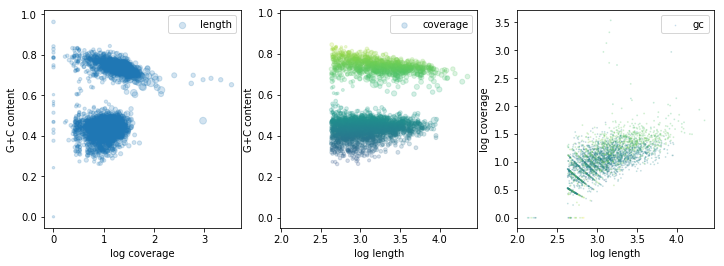

In [11]:
stu = clg[clg.student=="student83"]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(stu.log_coverage,stu.gc,s=0.5*np.sqrt(stu["len"]),alpha=0.2, label="length")
plt.xlabel("log coverage")
plt.ylabel("G+C content")
plt.legend()

plt.subplot(1,3,2)
plt.scatter(stu.log_len,stu.gc,s=10*np.sqrt(stu["coverage"]),c=stu.gc,alpha=0.2, label="coverage")
plt.xlabel("log length")
plt.ylabel("G+C content")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(stu.log_len,stu.log_coverage,s=np.sqrt(stu.gc),c=stu.gc,cmap="viridis",alpha=0.2, label="gc")
plt.xlabel("log length")
plt.ylabel("log coverage")
plt.legend()
plt.show()


And just for the heck of it, let's make a 3D scatterplot with all 3 variables


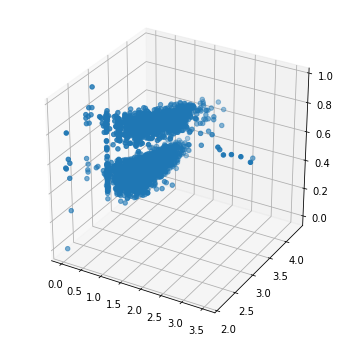

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(stu.log_coverage,stu.log_len,stu.gc)
plt.show()

There are clearly 2 clusters here, which means that student83 probably co-cultured two microorganisms together and sequenced them both. They seem to both have similar distributions in length and coverage, but very different G+C content

Now we're going to look at a few different machine learning algorithms that might help us separate them back out again. 

## k-means Clustering

### Algorithm

### Application

## DBSCAN Clustering

### Algorithm

### Application

## Agglomerative Clustering

### Algorithm

### Application

## Spectral Clustering

### Algorithm

### Application

## Gaussian Mixture Model Clustering

### Algorithm

### Application